This is the training and testing for model oneTraining size: 4200
Testing size: 1800
Epoch 1/10, Train Loss: 0.5131, Train Accuracy: 0.7948, Test Accuracy: 0.8272
Epoch 2/10, Train Loss: 0.2755, Train Accuracy: 0.8948, Test Accuracy: 0.9089
Epoch 3/10, Train Loss: 0.2607, Train Accuracy: 0.8998, Test Accuracy: 0.9033
Epoch 4/10, Train Loss: 0.2223, Train Accuracy: 0.9167, Test Accuracy: 0.8783
Epoch 5/10, Train Loss: 0.2119, Train Accuracy: 0.9212, Test Accuracy: 0.8511
Epoch 6/10, Train Loss: 0.1382, Train Accuracy: 0.9502, Test Accuracy: 0.9628
Epoch 7/10, Train Loss: 0.1147, Train Accuracy: 0.9590, Test Accuracy: 0.9622
Epoch 8/10, Train Loss: 0.1086, Train Accuracy: 0.9617, Test Accuracy: 0.9611
Epoch 9/10, Train Loss: 0.1077, Train Accuracy: 0.9610, Test Accuracy: 0.9656
Epoch 10/10, Train Loss: 0.1051, Train Accuracy: 0.9626, Test Accuracy: 0.9700


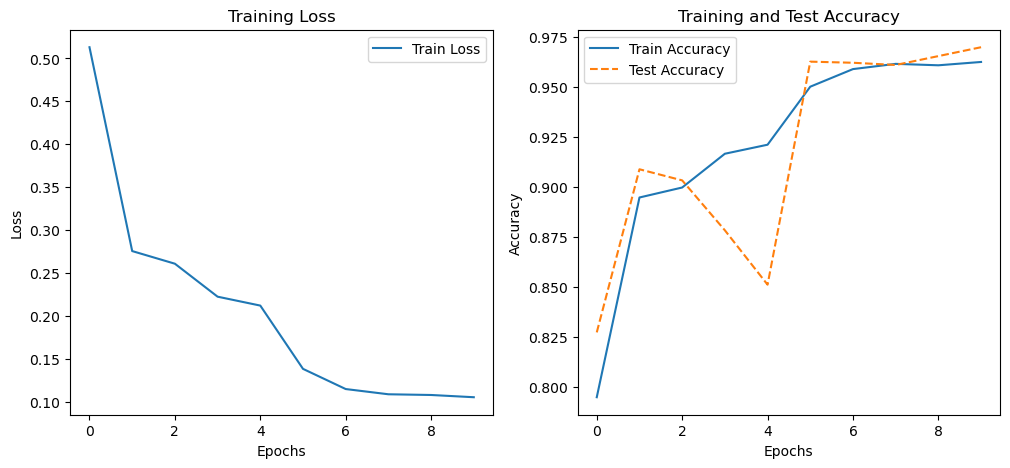

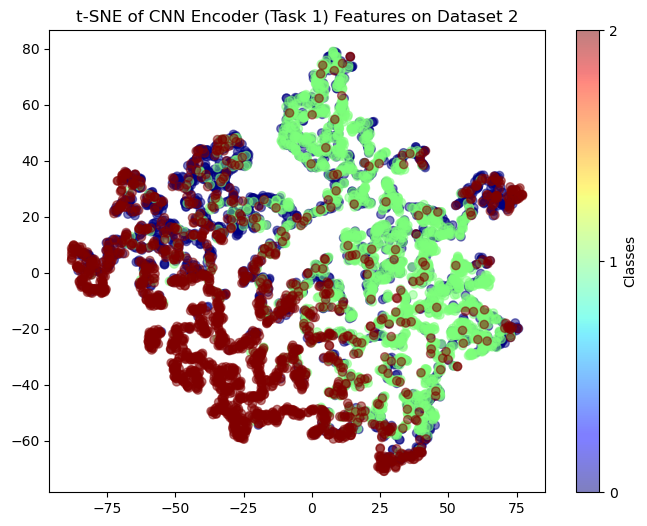

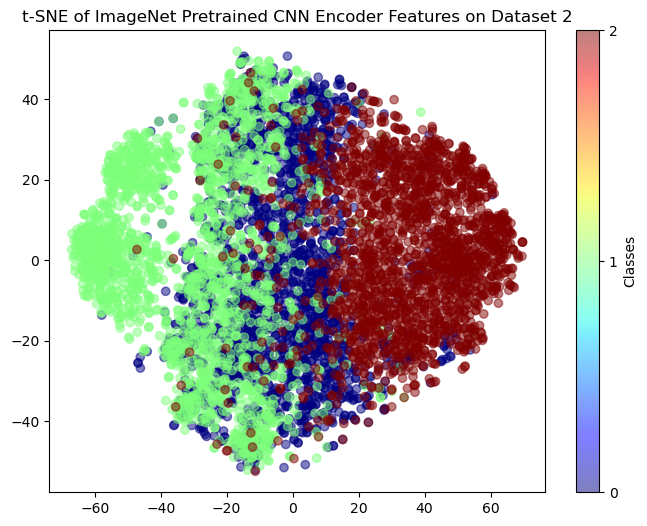

Classification Accuracy on Dataset 2 (using CNN Encoder from Task 1): 0.6122


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Training model from Task1
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


data_dir = './Dataset 1/Colorectal Cancer'
dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)


train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Training size: {train_size}")
print(f"Testing size: {test_size}")


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


num_epochs = 10
train_loss_history, train_acc_history, test_acc_history = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    scheduler.step()
    
    
    model.eval()  
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    test_acc_history.append(test_acc)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(test_acc_history, label="Test Accuracy", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()
plt.show()


# Task2 Dataset2
data_dir_2 = './Dataset 2/Prostate Cancer'  
dataset_2 = datasets.ImageFolder(root=data_dir_2, transform=data_transforms)
test_loader_2 = DataLoader(dataset_2, batch_size=64, shuffle=False)

# Extract features from Dataset 2 using the CNN encoder from Task 1
def extract_features(model, dataloader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

# CNN encoder trained on Dataset 1 applied to Dataset 2
features_1, labels_1 = extract_features(model, test_loader_2)

# Use an ImageNet-pretrained ResNet18 encoder on Dataset 2
model_pretrained = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model_pretrained.fc = nn.Identity()  
model_pretrained = model_pretrained.to(device)

features_2, labels_2 = extract_features(model_pretrained, test_loader_2)

# Visualize with t-SNE
def plot_tsne(features, labels, title):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    features_tsne = tsne.fit_transform(features_scaled)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap="jet", alpha=0.5)
    plt.colorbar(scatter, ticks=np.unique(labels), label="Classes")
    plt.title(title)
    plt.show()

# Plotting t-SNE 
plot_tsne(features_1, labels_1, "t-SNE of CNN Encoder (Task 1) Features on Dataset 2")
plot_tsne(features_2, labels_2, "t-SNE of ImageNet Pretrained CNN Encoder Features on Dataset 2")


scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_1)  

classifier = LogisticRegression(max_iter=1000)
classifier.fit(features_scaled, labels_1)

# Check classification accuracy on Dataset 2
accuracy = classifier.score(features_scaled, labels_1)
print(f"Apply the model of Task 1 on Dataset2, classification Accuracy on Dataset 2 (using CNN Encoder from Task 1): {accuracy:.4f}")